<a href="https://colab.research.google.com/github/DanilSavine/MasterCourse_NLP_and_LLMs/blob/main/hw_imdb_text_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import string

# HW Instructions

## 🚧 Cells
All the cells identified with a 🚧 should be completed, either by a code or an written answer.
You can add as many cells as you want, but in general cells are already in place.


🚧 **TODO** 🚧

*Requires to complete a code (can be completed with optional text cells if you find it relevant).*

or

🚧 **Question** 🚧

*Requires a written answer (can be completed with optional code cells if you find it relevant).*

## 🔴 Test cells
Cells identified with 🔴 should be left untouched and shouldn't return any error.

## Presentation
The overall presentation of the notebook will account in the grading process.
Some advice:
- Give title to your figures.
- Put legends on the figures.
- Comment the figures if they are not self-explanatory.
- Add comment in the code if not self-explanatory.
- Review your notebook before submitting.
- Feel free to add any additional illustration if you find it will bring something.
- Remain as concise as possible when answering written answer, emphasize the important points.

**We cannot debug every notebooks. The notebook should run entirely from the start to the end without any error. If one cell returns an error during the execution, only the cells before the error will be graded.**



# HW Introduction

## Hands on with NLP preprocessing

This first TP is here to make you experiment with the first preprocessing steps, necessary but often not emphasized enough.

## Plan

1. Load the data
2. Analyze and clean the text data
3. Format the texts for NLP (i.e. tokenize, etc).

## Notations

Throughout the HW, a text will be called either **document** or **text**.


# I - Data loading

In [127]:
def download_imdb(output_path: str, force_download: bool = False):
    """Save the data to `output_path`."""
    output_path = Path(output_path)
    if (not output_path.is_file()) or force_download:
        gdd.download_file_from_google_drive(
            file_id="1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz",
            dest_path=output_path,
        )
    return

In [128]:
DATA_PATH = "data/imdb_reviews.csv"
download_imdb(output_path=DATA_PATH, force_download=False)

🚧 **TODO** 🚧

Read the file to a Pandas dataframe (the file is stored as a csv). Make sure the "review" field is of dtype `string` and label of dtype `int`.

Hint: https://pandas.pydata.org/docs/user_guide/text.html (you can specify the `dtype` argument of pandas constructor).


In [129]:
df_imdb = pd.read_csv(DATA_PATH, dtype={"review": "string", "label": int})

In [130]:
text_column = df_imdb["review"]
label_column = df_imdb["label"]

🔴 **TEST**

In [131]:
assert text_column.dtype == "string"
assert label_column.dtype == int

🚧 **TODO** 🚧

Print some values of the dataframe.
- Print 3 samples of text.
- Print their associated labels.
- Print some statistics of the dataset.



In [132]:
print("==== 3 first texts ====")
for text in text_column[:3]: print(text)


print("\n==== Associated labels of the 3 first texts ====")
for label in label_column[:3]: print(label)


print("\n=== Dataset statistics ===")
print("Number of texts")
print(len(text_column))


print("\nAverage text length (in characters)")
average_length = int(np.mean([len(text) for text in text_column]))
print(average_length)


print("\n% of positive texts")
percentage = (np.sum(label_column) / len(label_column)) * 100
print("{:.2f}%".format(percentage))

==== 3 first texts ====
Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.
This is an example of why the majority of action films are the same. Generi

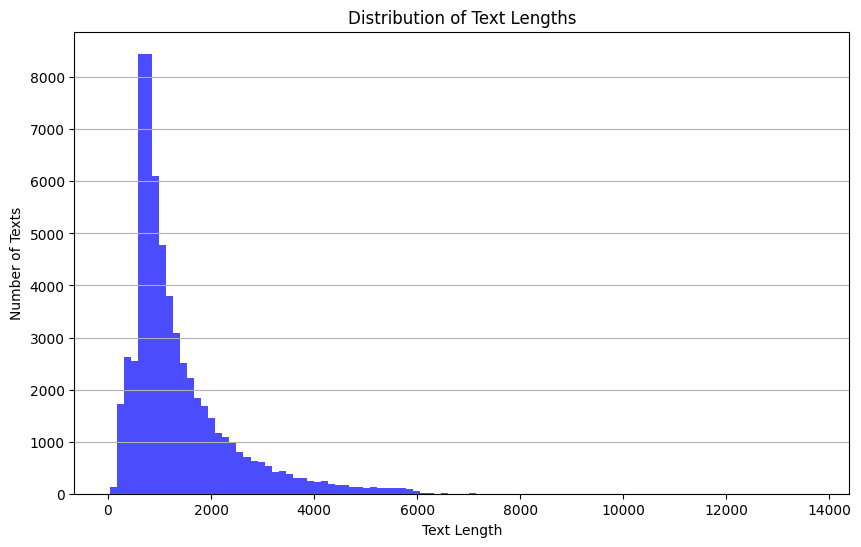

In [133]:
# Histogram for distribution of text lengths:
lengths = [len(text) for text in text_column]
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Number of Texts')
plt.grid(axis='y')
plt.show()

## II - Clean and format the data.
For this first TP, we want to focus on very simple tasks.
Therefore, we want to avoid as much as possible rare and uncommon words that will be considered as outliers.

We will try to figure out what kind of cleaning we can perform, by having a look at the data.

The plan for this part will be:
1. Split the strings as a list of words.
2. Find the outliers in the corpus.
3. Propose some methods to clean them.

### 1. Tokenization
First, we will split our texts into words.
Splitting a string into a list of smaller substrings is called **tokenization**, and the substrings are called **tokens**.

The simplest way to tokenize a text is to split it by words, according to whitespaces.

Then, each word encountered in the training set is stored and uniquely identified through an id.



🚧 **Question** 🚧

By doing so, we put a huge emphasis on words within documents.

a) Intuitively, why is it relevant? For instance compare to splitting by character.

b) Cite some methods discussed during the course that rely on word-based representations of documents.

**Answer**

a) Intuitevely, words carry semantics so they might carry positive or negative signals helpful to classify reviews. For example, "amazing" would be more meaningful semantically than the presence its individual letters.

b) Word-based respresentations methods are used in bag-of-words, TF-IDF, and pre-training of word embeddings. These representations are then used in classifiers such as logistic regression or (convolutional) neural networks.  

🚧 **TODO** 🚧

Implement a tokenizer based on whitespace splitting. For now, the tokenizer should only be able to store each unique word found in the dataset.

In [134]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split(sep = " ")

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None
                if token_not_in_vocab:
                    self.vocab[token] = current_id
                    self.id_to_token[current_id] = token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

🔴 **TEST**

In [135]:
toy_corpus = ["a cat", "a dog"]
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(toy_corpus)
assert tokenizer.vocab == {"a": 0, "cat": 1, "dog": 2}
assert tokenizer.frequencies == {0: 2, 1: 1, 2: 1}
assert tokenizer.num_words == 3

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 3 words.


🚧 **TODO** 🚧

Fits the tokenizer on the imdb reviews.

In [136]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(text_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 475277 words.


### 2. Noise analysis

🚧 **TODO** 🚧

Print 50 random tokens.

In [137]:
print(random.sample(list(tokenizer.vocab.keys()), 50))


['shoes.<br', "'dreadful", 'meriting', 'Miaugi', 'TKoQ', "away.....I'm", 'Flat,', 'Master\\".', 'confirm)', 'equally-messed-up', 'earth!', 'hallo!', '{read:mad}', 'Wilding,', 'sounds.', 'Louis\\"', "Run'n'Coke.", 'techno', 'SjÃ¶man', "Hammerstein's", 'Alleged', "1960's?", 'envisions.<br', "'forbidden'", 'Filho"', "she's...DEAD!...Must", 'constraints,', 'better....what', 'Hydro-Man', '/>Truancy,', 'symbolism?', 'serial)', 'rankings.', '"1928"', 'of...).', 'falconer', 'doctors...', 'Jane;', 'unidiomatic', 'self-deprecating.', 'riddance."', '\\burlesque\\"', '(surprising', '"mood', 'afterwords?', 'killngs', 'Unidentified', 'Kluznick,who', "joke'", 'subtlety,']


🚧 **QUESTION** 🚧

What do you think of the tokens? Do they look like simple "words" as expected?

Analyze the noise and explain why we got such weird vocabulary.

**Answer**

No they don't look like simple words. We have a lot of additional characters that might not carry semantic meaning like HTML tags, punctuation, etc. This comes from the fact that we have used only the space for the split.
Probably the issue comes from data acquisition.

### 3. Cleaning

🚧 **TODO** 🚧

You are going to implement some of the classical cleaning methods.
1. Lower case the string.
2. String normalization, i.e., replace accentuated characters by standard version ("â -> a") (hint: https://stackoverflow.com/a/14121678).
3. Remove non alpha-numeric characters (use Python regex package `re`).
4. Replace numeric characters by the token `'<NUM>'` (use the package `re`).
5. Remove double whitespaces (use the package `re`).


In [138]:
import unicodedata
import re

In [139]:
def preprocess_text(text: str) -> str:
    # lower case
    text = text.lower()
    # string normalization.
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    # remove non alpha numeric characters.
    text = re.sub(r"[^a-zA-Z0-9]", ' ', text)
    # replace numbers by the <NUM> token.
    text = re.sub(r"\d+", '<NUM>', text)
    # remove double whitespaces.
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [140]:
noisy_text = "Ï   lîved  in.  San-Françisco...  ! for 12 years."
clean_text = "i lived in san francisco for <NUM> years"
print(preprocess_text(noisy_text))
assert preprocess_text(noisy_text) == clean_text

i lived in san francisco for <NUM> years


🔴 **TEST**

In [141]:
noisy_text = "Ï   lîved  in    San-Françisco...  ! for 12 years."
clean_text = "i lived in san francisco for <NUM> years"
assert preprocess_text(noisy_text) == clean_text

🚧 **TODO** 🚧

Add column `clean_review` to the dataframe, with the clean text.

Store the `clean_review` column to the variable `clean_column`.

In [142]:
# Applying preprocessing to the reviews
df_imdb["clean_review"] = df_imdb["review"].apply(preprocess_text)

clean_column = df_imdb["clean_review"]

In [143]:
clean_column

0        once again mr costner has dragged out a movie ...
1        this is an example of why the majority of acti...
2        first of all i hate those moronic rappers who ...
3        not even the beatles could write songs everyon...
4        brass pictures movies is not a fitting word fo...
                               ...                        
62150    i am a student of film and have been for sever...
62151    unimaginably stupid redundant and humiliating ...
62152    guy is a loser can t get girls needs to build ...
62153    this <NUM> minute documentary bunuel made in t...
62154    i saw this movie as a child and it broke my he...
Name: clean_review, Length: 62155, dtype: object

🚧 **TODO** 🚧

Run the tokenizer on the clean text and print 50 random tokens.

In [144]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 101917 words.


In [145]:
print(random.sample(list(tokenizer.vocab.keys()), 50))

['carnagie', 'straightforwardness', 'kaarlo', 'soutendjik', 'likeliest', 'potocnik', 'aggro', 'intersperse', 'finnlayson', 'critisize', 'zombi', 'snitcky', 'slasha', 'slapped', 'inculcated', 'mcclinton', 'groundlessly', 'cloned', 'stigma', 'themselfs', 'unwarily', 'lohde', 'interruption', 'exterminators', 'hickman', 'sodomizes', 'memebership', 'housed', 'caterers', 'henshall', 'toma', 'pym', 'heretical', 'watchablity', 'maximum', 'bread', 'undried', 'gladiators', 'repenting', 'mostof', 'himmesh', 'arrosseur', 'subsidize', 'bekins', 'eidlemann', 'schurenberg', 'nerdish', 'chasing', 'fertile', 'preside']


🚧 **Question** 🚧

What do you think of the new tokens? Are they better? What common noise still remain? (Feel free to print more tokens to get a better intuition).

Suggest some methods to improve again the tokenization (at least 2), based on either these results or on something you think we could have done better.

**Answer**

There remains noise in the form of:
* Typos or simply different spellings of the same word (e.g. british vs. american english)
* Lack of space between words that should have spaces (e.g. filmovie)
* Conjugation of verbs and plural forms (e.g. watched, watching, watches)
* Different langages (some of the words are in german)

To improve the results we could
* Introduce a spell checker
* Perform stemming, especially to deal with conjugated verbs or plurals
* Introduce a method to deal with contraced forms like I'm or Can't



### Tokens analysis


🚧 **TODO** 🚧

Show the frequencies repartition.
This should be a histogram, with 100 bins, with the frequencies on the x axis and the number of words associated to the frequencies on the y axis (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

Use logarithm scale for y.

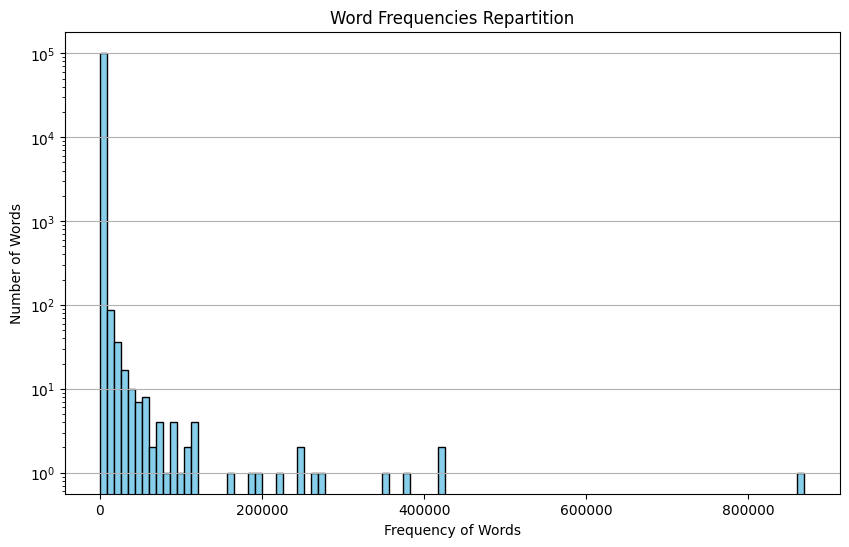

In [146]:
plt.figure(figsize=(10, 6))
plt.hist(tokenizer.frequencies.values(), bins=100, log=True, color='skyblue', edgecolor='black')
plt.title('Word Frequencies Repartition')
plt.xlabel('Frequency of Words')
plt.ylabel('Number of Words')
plt.grid(axis='y')
plt.show()

🚧 **Question** 🚧

What do you think of the repartition?

**Answer**

The repartition is skewed towards 0, with a lot of wors only present once. We could either not use them or spend more time working on the preprocessing (to correct spelling, use stemming)
Also we have some words that are outliers, with more than 300k occurancies. These might be words such as "a", "the", etc. that might not carry a lot of meaning for our task.


🚧 **TODO** 🚧

Plot the frequencies repartition. Find the best corresponding Zipf law (seen during the course) and plot it on the same figure.

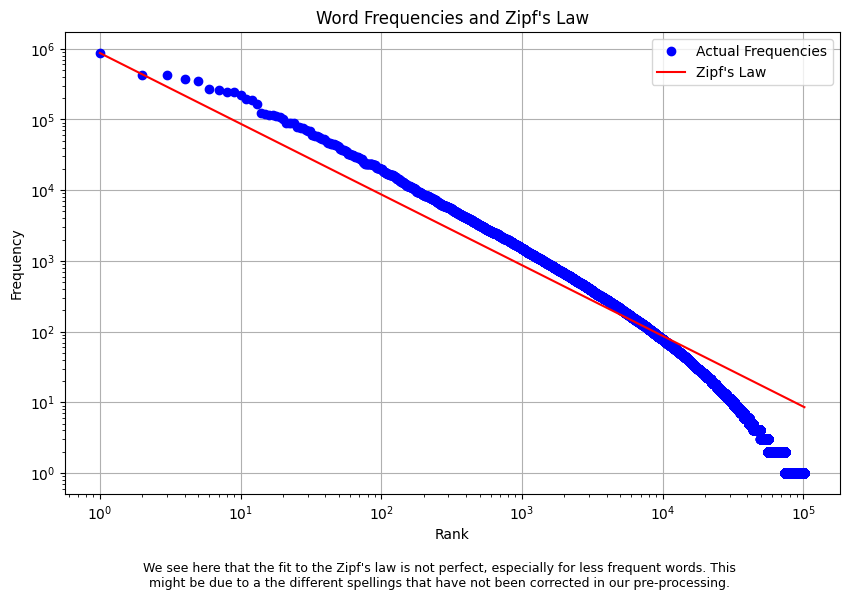

In [168]:
# Sort word frequencies from high to low
sorted_frequencies = sorted(list(tokenizer.frequencies.values()), reverse=True)

# Rank the word frequencies
ranks = np.arange(1, len(sorted_frequencies) + 1)

# The value of c is the frequency of the most common word
c = sorted_frequencies[0]

# Predict frequencies using Zipf's law
predicted_frequencies = c / ranks

fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(ranks, sorted_frequencies, marker='o', linestyle='', label='Actual Frequencies', color='blue')
ax.loglog(ranks, predicted_frequencies, linestyle='-', label="Zipf's Law", color='red')

ax.set_title('Word Frequencies and Zipf\'s Law')
ax.set_xlabel('Rank')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True)

import textwrap

text = "We see here that the fit to the Zipf's law is not perfect, \
especially for less frequent words. This might be due to different spellings\
 that have not been corrected in our pre-processing."
wrapped_text = textwrap.fill(text, width=100)

fig.text(0.5, -0.05, wrapped_text, ha='center', va='bottom', fontsize=9, wrap=True)

plt.show()

## III - DataLoading

This final part aims at making your dataset compatible with PyTorch.

### Text representation

Since we plan to work with PyTorch, we need to work with `tensors`. But since a text is only composed of strings, we need to find some numerical representations for the text.

The most basic method is to represent a text by list of tokens. We already used a simple WhiteSpace tokenizer earlier to analyze our texts before cleaning. Now we will use it to *represent* the texts.

🚧 **TODO** 🚧

Modify the code of the `WhiteSpaceTokenizer` so that it could encode a text into a list of token ids and do the reverse (i.e. decode a list of token ids to a text).

In [148]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split(" ")

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        return [self.vocab.get(token, "<UNK>") for token in self.split_text(text)]

    def decode(self, ids: List[int]) -> str:
        """Take a list of ids as input and return its associated text."""
        return " ".join([self.id_to_token.get(id, "<UNK>") for id in ids])

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None

                if token_not_in_vocab:
                    self.vocab[token] = current_id
                    self.id_to_token[current_id] = token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

🔴 **TEST**

In [149]:
tokenizer = WhiteSpaceTokenizer()
toy_dataset = ["the cat is in the kitchen", "i have a dog"]
tokenizer.fit(toy_dataset)
text = "i have a kitchen"
assert tokenizer.encode(text) == [5, 6, 7, 4]
assert tokenizer.decode([0, 1, 2, 7, 8]) == "the cat is a dog"

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 9 words.


🚧 **TODO** 🚧 Now fit it on your dataset.

In [150]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 101917 words.


🚧 **Question** 🚧
Look at the following code:

In [151]:
tokenizer.encode("the king is in the câstle")

[16, 3510, 57, 39, 16, '<UNK>']

a) Does it raise an exception? Explain what is the problem with the above situation.

b) In which real life scenario could such a situation appear?

**Answer**

câstle is not recognized as a token in our dictionnary. So we have an error when a token we try to encode is not in the dictionnary / has not been seen during the construction of the dictionnary

This situation might appear in real life with proper nouns, typos, rare common nouns, etc.


🚧 **TODO** 🚧

Propose a simple modification of the tokenizer code such that it doesn't raise an exception anymore. It should handle the presence of any unknown token.

The following code should't raise any exception.

** Answer **

I have used the get method to query the dictionnary with a 'UNK' default value

🔴 **TEST**

In [152]:
allowed_characters = (string.ascii_uppercase + string.digits).replace(" ", "")
for _ in range(1000):
    word_that_do_not_exist = "".join(random.choices(allowed_characters, k=100))
    encoding = tokenizer.encode(f"the king is in the {word_that_do_not_exist}")
    assert tokenizer.decode(encoding) == "the king is in the <UNK>"

### Dataset for PyTorch
We will be working wtth PyTorch most of the time.
A good practice is to always iterate through a `torch.utils.data.DataLoader`, coupled with `torch.utils.data.Dataset`.

🚧 **TODO** 🚧

We will construct our custom `Dataset` class, that should be fully compatible with the PyTorch API. According to the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), such a dataset should implement at least three methods, `__init__`, `__len__`, `__getitem__`. Complete the following code such that the dataset yields a list of texts.

Requirements:
1. The dataset class should read the data from the csv_file stored in `DATA_PATH`.
2. The dataset should output the raw text, without any cleaning.

In [153]:
from torch.utils.data import Dataset


class IMDBDataset(Dataset):
    def __init__(self, file_path: str):
        self.df = pd.read_csv(file_path, dtype={"review": "string", "label": int})

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        return self.df.iloc[idx]["review"], self.df.iloc[idx]["label"]

🔴 **TEST**

In [154]:
imdb_dataset = IMDBDataset(file_path=DATA_PATH)
text, label = imdb_dataset[0]
assert text == text_column[0]
assert label == label_column[0]

### DataLoader for PyTorch

Now that the dataset is ready, we should be able to iterate through it. This is done with a `DataLoader`.

The `DataLoader` also has some handy functionnalities:
1. Batch iteration.
2. Collate function.

The collate function corresponds to the argument `collate_fn` of the constructor of `torch.utils.data.DataLoader`.

This function is applied on the fly to each sample of the dataset.

Our `IMDBDataset` only outputs raw texts. During the iteration through the `DataLoader`, we would like to:
1. Clean the dataset with our cleaning function `preprocess_text`.
2. Convert the text to a list of tokens.
3. The `DataLoader`, for a batch size of `N`, should yield a dictionnary `{"token_ids": ..., "labels": ...,}` with `"token_ids"` corresponding to a list of `N` lists of tokens ids, and `"labels"` to a list of size `N` with the corresponding labels.

🚧 **TODO** 🚧

Write the `collate_fn` function so that the above requirements are satisfied (i.e., clean and tokenize).

In [155]:

def collate_fn(batch):
    """Unpacks the batch, preprocesses and encodes text, and returns a dict with labels"""

    reviews, labels = zip(*batch)

    reviews = [preprocess_text(r) for r in reviews]

    token_ids = [tokenizer.encode(r) for r in reviews]

    return {"token_ids": token_ids, "labels": labels}


In [156]:
from torch.utils.data import DataLoader

🔴 **TEST**

In [157]:
for batch_size in range(1, 10):
    dataloader = DataLoader(
        dataset=imdb_dataset, batch_size=batch_size, collate_fn=collate_fn
    )
    for batch in dataloader:
        token_ids = batch["token_ids"]
        labels = batch["labels"]
        assert len(token_ids) == batch_size
        assert len(labels) == batch_size
        assert isinstance(token_ids[0][0], int)
        assert (isinstance(labels[0], int)) or isinstance(labels[0], np.int64)
        break

🚧 **Question** 🚧

Write a concise summary on what you learned with this lab.

**Answer**

* Build a tokenizer class from a corpus to encode and decode texts and tokens
* Clean text using regex and normalization
* Deal with exceptions (e.g. words out of vocabulary)
* Explore vacubalary with histograms and fitting to a Zipf's Law
* Use PyTorch's Dataset and DataLoader classes